# Mein Projekt

Erkenntnisse
-----
- Abstand zwischen zwei Punkten im Raster ~48 (da dst(ox, origin) & dst(oy, origin) ~144)
- Abstand zwischen zwei Punkten im Raster, diagonal = sqrt(48^2 + 48^2) ~ 68, mit Messwerten verifizierbar
- Abweichung von theoretischer zu echter Distanz o,x bzw. o,y ~10%

ToDo
----
- test for different touchcodes

In [1]:
samples = {}

samples[0x1] = [[(360,483),(523,620),(366,631),(413,488)]]

"""valid samples for touchcode 0x80"""
samples[0x80] = [[(1643,614),(1450,649),(1555,663),(1568,731)],
           [(577,629),(379,577),(471,631),(453,701)],
           [(1486,68),(1638,213), (1581,119),(1628,69)],
           [(1676,651),(1530,799),(1619,750),(1675,791)],
           [(176,469), (320,324),(225,373),(175,324)],            
           [(725,544),(860,697),(819,599),(869,557)],
           [(346,509),(494,368),(399,415),(346,367)],
           [(769,593),(750,792),(793,695),(865,701)],
            [(269,202),(477,205),(375,164),(382,93)]]
    
"""valid samples for touchcode 0x10"""
samples[0x10] = [[(552,647),(363,572),(467,578),(423,707)],
                 [(382,429),(464,244),(452,345),(325,294)],
                [(1533,244),(1540,447), (1500,346),(1641,334)],
                [(199,589),(405,620),(302,637),(320,505)]]

"""invalid samples (touchcode -1)"""
samples[-1] = [[(303,152), (379,577),(368,171),(368,285)],
           [(1473,235),(1417,328),(1563,340),(1624,263)]]

In [2]:
import collections
import itertools
import numpy as np
from operator import itemgetter
from scipy.spatial import distance
import re

DEBUG = False

"""Vector stuff"""

def v_same_orientation(v1, v2):
    return np.dot(v1, v2) > 0
    
"""Division by zero problem!"""
def v_angle(v1, v2):
    length_v1 = np.linalg.norm(v1)
    length_v2 = np.linalg.norm(v2)
    
    if length_v1 == 0 or length_v2 == 0:
        return 0
    
    return np.round(np.degrees(np.arccos(np.dot(v1, v2) /  length_v1 * length_v2)))

def v_perpendicular(v1, v2, tolerance_deg = 0):
    return in_range(v_angle(v1, v2), 90, 5)

def v_parallel(v1, v2, tolerance_deg = 0):       
    return in_range(v_angle(v1, v2), 0, 5) or in_range(v_angle(v1, v2), 180, 5)

def in_range(value, target, tolerance):
    return target - tolerance <= value <= target + tolerance

def v_rotate(matrix, angle):
    """rotates the given matrix by angle in degrees, counter clockwise."""
    angle = np.radians(angle)
    rot_matrix = np.array( [ [ np.cos(angle), -np.sin(angle)], [ np.sin(angle), np.cos(angle)] ] )
    return np.dot(rot_matrix, matrix)
    

"""Helpers"""

def log(message):
    """Prints a message only if DEBUG = True, so that all printing to stdout can be easily disabled."""
    if DEBUG:
        print(message)

def are_same(reference, value, percentage):
    min_value = reference - reference * percentage
    max_value = reference + reference * percentage
    result = min_value < value < max_value
    
    return result

"""Heavy stuff"""

def string_to_coords(coord_string):
    """
    Checks and decodes a coordinates string (that is passed to the API on the command line) into coordinates.
    Returns an empty list if it is not well formed.
    """
    if not isinstance(coord_string, str):
        return []
    
    coord_string = re.sub(r'\s+', '', coord_string, flags=re.UNICODE)
    is_well_formed = re.match(r'\[(\(\d+,\d+\),){0,}(\(\d+,\d+\))\]', coord_string)
    
    return eval(coord_string) if is_well_formed else []


def approximates(ref_point, point, max_deviation):
    """Helper function to check if two points are the same within the specified deviation."""
    
    x = ref_point[0] - max_deviation <= point[0] <= ref_point[0] + max_deviation
    y = ref_point[1] - max_deviation <= point[1] <= ref_point[1] + max_deviation
    
    return x and y


def get_orientation_marks(points):
    """
    Extract the reference system (o, vx, vy) from a set of points. 
    
    Returns None if no reference system found.
    """
    p_threshold = 0.10

    # no touchcode if there are not enough points
    if points is None or len(points) < 3:
        return None
    
    # calculate all possible distances between all points
    vectors = [(p1, p2, distance.euclidean(p1, p2)) for p1, p2 in list(itertools.combinations(points, 2))]

    # get the two points that have the longest distance (those are vx and vy)
    v1, v2, longest_distance = max(vectors, key=itemgetter(2))
    
    log("v1: {0}, v2: {1}, dst(v1, v2): {2}]".format(v1, v2, longest_distance))
    
    origin = None
    candidates = []
    
    # find the origin candidates by getting all distances that are longest_distance / sqrt(2)    
    for vector in vectors:
        if are_same(longest_distance / np.sqrt(2), vector[2], p_threshold):
            if np.array_equal(vector[0], v1) or np.array_equal(vector[0], v2):
                candidates.append((vector[1][0], vector[1][1]))
            if np.array_equal(vector[1], v1) or np.array_equal(vector[1], v2):
                candidates.append((vector[0][0], vector[0][1]))
    
    # find the origin (the point that we got twice)
    try:
        origin = np.array([k for k, v in collections.Counter(candidates).items() if v == 2])[0]
    except:
        return None
    
    return find_vx_vy_new(np.array([origin,v1,v2]))

def find_vx_vy_new(m):
    """
    Given three points (origin, v1, v2), finds out which of v1, v2 is vx and vy.
    
    Input: A 2x3 matrix (origin, v1, v2)
    Output: A 2x3 matrix (origin, vx, vy)
    """
    
    # The standard coordinate system
    positive_x = np.array([1,0])
    positive_y = np.array([0,1])
    real_origin = np.array([0,0])
    
    # The origin of our touchcode system
    origin = m[0]
    
    # Translate the touchcode coordinate system to have its origin at the standard origin (0,0)
    translation_vec = real_origin - origin
    mt = m + translation_vec
    
    v1, v2 = mt[1], mt[2]
    log("v1 is {0}".format(v1))
    
    # Pick v1 as a pivot and check if it is in first or fourth quadrant.
    # If so, rotate by angle(v1, positive_y) to align v2 with the x-axis.
    # Next, check whether v2 has the same orientation as the positive x-axis, v1 then being vx. 
    # In the other case, v1 is the vx.
    if v_same_orientation(v1, positive_x):
        log("v1 is oriented with positive_x")
        angle = v_angle(v1, positive_y)
        log("angle: {0}".format(angle))
        v1 = v_rotate(v1, angle)
        v2 = v_rotate(v2, angle)
    else:
        log("v1 is NOT oriented with positive_x")
        angle = 360 - v_angle(v1, positive_y)
        v1 = v_rotate(v1, angle)
        v2 = v_rotate(v2, angle)
    
    log(v_same_orientation(v2, positive_x))
    log("after rot: v1 = {0} and v2 = {1}".format(v1, v2))
    if v_same_orientation(v2, positive_x):
        return np.array([m[0],m[2],m[1]])
    else:
        return m

def norm(reference, point):
    """Given a reference system (o, vx, vy), normalize a set of points to new coordinates."""
    o = reference[0]
    x = reference[1]
    y = reference[2]
    s = point
    
    # Richtungsvektoren entlang der Kanten vom Referenzsystem
    vx = x - o
    vy = y - o
    # Ortsvektor des Punkts bzgl o (wo ist s bgzl des neuen Ursprungs o)
    so = s - o
    
    # Normierung der Richtungsvektoren    
    vx = (vx/(np.linalg.norm(vx)))/(np.linalg.norm(vx))*3
    vy = (vy/(np.linalg.norm(vy)))/(np.linalg.norm(vy))*3
   
    xcor = np.dot(vx, so)
    ycor = np.dot(vy, so)
    
    log("s.x: {0}, s.y: {1}".format(xcor, ycor))
    
    return (round(xcor, 1), round(ycor, 1))


def touchcode_from_points(points):   
    """Generate touchcode for a set of normalized touchpoints."""
    
    touchcode = 0
    touchpoint_map = {
        (1,3): 0x001,
        (2,3): 0x002,
        (0,2): 0x004,
        (1,2): 0x008,
        (2,2): 0x010,
        (3,2): 0x020,
        (0,1): 0x040,
        (1,1): 0x080,
        (2,1): 0x100,
        (3,1): 0x200,
        (1,0): 0x400,
        (2,0): 0x800
    }
    
    for touchpoint, tc_bit in touchpoint_map.items():
        if any(map(lambda point: approximates(touchpoint, point, 0.2), points)):
            touchcode |= tc_bit
    
    return touchcode

def xmirror(points, max_y):
    mirrored_points = []
       
    for point in points:
        mirrored_points.append((point[0], max_y - point[1]))
        
    return mirrored_points

def check_touchcode(points, x_mirror=True, max_y=1080):
    """Main API function. Takes a list of points, finds the reference system in it and tries to decode 
    the corresponding touchcode.
    
    Returns: A touchcode from 0 to 4095 (12 bit) or -1 if no touchcode could be decoded.
    """       
    no_result = -1
    
    if points is None or not isinstance(points, list):
        return no_result
    
    if x_mirror:
        points = xmirror(points, max_y)
    
    reference_system = get_orientation_marks(points)
     
    if reference_system is None:
        return no_result
    
    touchpoints = [norm(reference_system, point) for point in points]
    
    return touchcode_from_points(touchpoints)

def check_touchcode_str(coord_string, x_mirror=True):
    """
    Wrapper around check_touchcode_lst to make it externally callable with a string of coordinates.
    """
    
    return check_touchcode(string_to_coords(coord_string), x_mirror)

In [7]:
import unittest
from unittest import *

class TestTouchcodeStrApi(TestCase):
    def test_happy_path(self):
        coord_string = "[(0,0),(0,3),(3,0),(2,3),(1,3)]"
        touchcode = check_touchcode_str(coord_string, False)
        self.assertEqual(touchcode, 3)
        
    def test_fail_path(self):
        coord_string = "[+++GARBAGE+++]"
        touchcode = check_touchcode_str(coord_string, False)
        self.assertEqual(touchcode, -1)

class TestTouchcodeApi(TestCase):
    def test_arg_is_empty_list(self):
        arg = []
        touchcode = check_touchcode(arg)
        self.assertEqual(touchcode, -1)
        
    def test_arg_is_empty_tuple(self):
        arg = ()
        touchcode = check_touchcode(arg)
        self.assertEqual(touchcode, -1)
        
    def test_arg_is_empty_dict(self):
        arg = {}
        touchcode = check_touchcode(arg)
        self.assertEqual(touchcode, -1)
        
    def test_arg_is_true(self):
        arg = True
        touchcode = check_touchcode(arg)
        self.assertEqual(touchcode, -1)
        
    def test_arg_is_false(self):
        arg = False
        touchcode = check_touchcode(arg)
        self.assertEqual(touchcode, -1)
        
    def test_arg_is_numeric(self):
        arg = 0
        touchcode = check_touchcode(arg)
        self.assertEqual(touchcode, -1)
        
    def test_arg_is_none(self):
        arg = None
        touchcode = check_touchcode(arg)
        self.assertEqual(touchcode, -1)
        
    def test_arg_is_empty_string(self):
        arg = ""
        touchcode = check_touchcode(arg)
        self.assertEqual(touchcode, -1)
        
    def test_arg_is_non_empty_string(self):
        arg = "this string is not empty"
        touchcode = check_touchcode(arg)
        self.assertEqual(touchcode, -1)
        
    def test_simple_case(self):
        arg = [(0, 0),(0, 3),(3, 0),(2, 3)]
        touchcode = check_touchcode(arg, x_mirror=False)
        self.assertEqual(touchcode, 0x2)
        
    def test_happy_path(self):
        for sample in samples[0x80]:
            touchcode = check_touchcode(sample)
            self.assertEqual(touchcode, 0x80)
        
        for sample in samples[0x10]:
            touchcode = check_touchcode(sample)
            self.assertEqual(touchcode, 0x10)
            
    def test_fail_path(self):
        for sample in samples[-1]:
            touchcode = check_touchcode(sample)
            self.assertEqual(touchcode, -1)
                        

class TestStringToCoords(TestCase):
    def test_none(self):
        arg = None
        coords = string_to_coords(arg)
        self.assertEqual(coords, [])
        
    def test_empty(self):
        arg = ""
        coords = string_to_coords(arg)
        self.assertEqual(coords, [])
        
    def test_number(self):
        arg = "3"
        coords = string_to_coords(arg)
        self.assertEqual(coords, [])
        
    def test_list_of_number(self):
        arg = "[1, 2, 3]"
        coords = string_to_coords(arg)
        self.assertEqual(coords, [])
        
    def test_one_coord(self):
        arg = "[(1,1)]"
        coords = string_to_coords(arg)
        self.assertEqual(coords, [(1,1)])
        
    def test_two_coords(self):
        arg = "[(1,1),(178312312,312312312321)]"
        coords = string_to_coords(arg)
        self.assertEqual(coords, [(1,1),(178312312,312312312321)])
        
    def test_more_coords(self):
        arg = "[(1,1),(178312312,312312312321),(2,3),(4,5),(0,0),(400,500)]"
        coords = string_to_coords(arg)
        self.assertEqual(coords, [(1,1),(178312312,312312312321),(2,3),(4,5),(0,0),(400,500)])

    def test_with_whitespaces(self):
        arg = "[(1,1)   ,   (    178312312,			312312312321),   (     2,3),(4,     5),(0,  0)    ,(400,500)]"
        coords = string_to_coords(arg)
        self.assertEqual(coords, [(1,1),(178312312,312312312321),(2,3),(4,5),(0,0),(400,500)])
        
        
class TestPointsToTouchcode(TestCase):
    def test_no_points(self):
        points = []
        touchcode = touchcode_from_points(points)
        self.assertEqual(touchcode, 0)
    
    def test_christmas_tree(self):
        points = [(1, 0), (2, 0), (0, 1), (1, 1), (2, 1), (3, 1), (0, 2), (1, 2), (2, 2), (3, 2), (1, 3), (2, 3)]
        touchcode = touchcode_from_points(points)
        self.assertEqual(touchcode, 0xFFF)
        
    def test_0x18(self):
        touchcode = touchcode_from_points([(1.1, 2.0), (1.8, 2.2)])
        self.assertEqual(touchcode, 0x18)
    
    def test_0x888(self):
        touchcode = touchcode_from_points([(1.1, 2.0), (1.1, 1.2), (2.0, 0.0)])
        self.assertEqual(touchcode, 0x888)
     
    def test_0x444(self):
        touchcode = touchcode_from_points([(0, 2), (0.1, 1.2), (1.0, 0.1)])
        self.assertEqual(touchcode, 0x444)
    
    def test_0x80_precise(self):
        points = [(1, 1)]
        touchcode = touchcode_from_points(points)
        self.assertEqual(touchcode, 0x80)
    def test_0x80_round(self):
        points = [(0.9, 1.1)]
        touchcode = touchcode_from_points(points)
        self.assertEqual(touchcode, 0x80)
    def test_0x80_round(self):
        points = [(1.2, 0.8)]
        touchcode = touchcode_from_points(points)
        self.assertEqual(touchcode, 0x80)
    def test_0x80_no_code(self):
        points = [(1.3, 0.7)]
        touchcode = touchcode_from_points(points)
        self.assertEqual(touchcode, 0)
    def test_no_fail_on_unknown_points(self):
        points = [(70, 100)]
        touchcode = touchcode_from_points(points)
        self.assertEqual(touchcode, 0)
        

class TestNormalization (TestCase):
    def test_normalize_to_simple_system(self):
        coords = (np.array([0,0]), np.array([3,0]), np.array([0,3]) )
        self.assertEqual(norm(coords, np.array([0, 0])), (0, 0))
        self.assertEqual(norm(coords, np.array([1, 0])), (1, 0))
        self.assertEqual(norm(coords, np.array([2, 0])), (2, 0))
        self.assertEqual(norm(coords, np.array([3, 0])), (3, 0))
        
        self.assertEqual(norm(coords, np.array([0, 1])), (0, 1))
        self.assertEqual(norm(coords, np.array([1, 1])), (1, 1))
        self.assertEqual(norm(coords, np.array([2, 1])), (2, 1))
        self.assertEqual(norm(coords, np.array([3, 1])), (3, 1))
        
        self.assertEqual(norm(coords, np.array([0, 2])), (0, 2))
        self.assertEqual(norm(coords, np.array([1, 2])), (1, 2))
        self.assertEqual(norm(coords, np.array([2, 2])), (2, 2))
        self.assertEqual(norm(coords, np.array([3, 2])), (3, 2))
        
        self.assertEqual(norm(coords, np.array([0, 3])), (0, 3))
        self.assertEqual(norm(coords, np.array([1, 3])), (1, 3))
        self.assertEqual(norm(coords, np.array([2, 3])), (2, 3))
        self.assertEqual(norm(coords, np.array([3, 3])), (3, 3))
               
    def test_normalize_to_rotated_system_90(self):
        coords = (np.array([3,3]), np.array([0,3]), np.array([3,0]) )
        self.assertEqual(norm(coords, np.array([0, 0])), (3, 3))
        self.assertEqual(norm(coords, np.array([1, 0])), (2, 3))
        self.assertEqual(norm(coords, np.array([2, 0])), (1, 3))
        self.assertEqual(norm(coords, np.array([3, 0])), (0, 3))
        
        self.assertEqual(norm(coords, np.array([0, 1])), (3, 2))
        self.assertEqual(norm(coords, np.array([1, 1])), (2, 2))
        self.assertEqual(norm(coords, np.array([2, 1])), (1, 2))
        self.assertEqual(norm(coords, np.array([3, 1])), (0, 2))
        
        self.assertEqual(norm(coords, np.array([0, 2])), (3, 1))
        self.assertEqual(norm(coords, np.array([1, 2])), (2, 1))
        self.assertEqual(norm(coords, np.array([2, 2])), (1, 1))
        self.assertEqual(norm(coords, np.array([3, 2])), (0, 1))
 
        self.assertEqual(norm(coords, np.array([0, 3])), (3, 0))
        self.assertEqual(norm(coords, np.array([1, 3])), (2, 0))
        self.assertEqual(norm(coords, np.array([2, 3])), (1, 0))
        self.assertEqual(norm(coords, np.array([3, 3])), (0, 0))
        
    def test_normalize_to_rotated_system_45(self):
        coords = (np.array([3,0]), np.array([3,3]), np.array([0,0]) )
        self.assertEqual(norm(coords, np.array([0, 0])), (0, 3))
        self.assertEqual(norm(coords, np.array([1, 0])), (0, 2))
        self.assertEqual(norm(coords, np.array([2, 0])), (0, 1))
        self.assertEqual(norm(coords, np.array([3, 0])), (0, 0))
        
        self.assertEqual(norm(coords, np.array([0, 1])), (1, 3))
        self.assertEqual(norm(coords, np.array([1, 1])), (1, 2))
        self.assertEqual(norm(coords, np.array([2, 1])), (1, 1))
        self.assertEqual(norm(coords, np.array([3, 1])), (1, 0))
        
        self.assertEqual(norm(coords, np.array([0, 2])), (2, 3))
        self.assertEqual(norm(coords, np.array([1, 2])), (2, 2))
        self.assertEqual(norm(coords, np.array([2, 2])), (2, 1))
        self.assertEqual(norm(coords, np.array([3, 2])), (2, 0))
        
        self.assertEqual(norm(coords, np.array([0, 3])), (3, 3))
        self.assertEqual(norm(coords, np.array([1, 3])), (3, 2))
        self.assertEqual(norm(coords, np.array([2, 3])), (3, 1))
        self.assertEqual(norm(coords, np.array([3, 3])), (3, 0))

    def test_with_samples_for_0x80(self):
        for sample in samples[0x80]:
            coords = np.array(sample)
            om = get_orientation_marks(coords)
            result = norm(om, sample[2])
            self.assertTrue(0.9 <= result[0] <= 1.1)
            self.assertTrue(0.9 <= result[1] <= 1.1)


class TestFindVxVy(TestCase):
    def test_with_standard_coordinates(self):
        o  = np.array([0, 0])
        v1 = np.array([0, 3])
        v2 = np.array([3, 0])
        m = np.array([o,v1,v2])
        
        expected_result = np.array([[0,0],[3,0],[0,3]])
        result = find_vx_vy_new(m)
        self.assertTrue(np.array_equal(expected_result, result))
        
        
    def test_with_standard_coordinates_swapped(self):
        o  = np.array([0, 0])
        v1 = np.array([3, 0])
        v2 = np.array([0, 3])
        m = np.array([o,v1,v2])
        
        expected_result = np.array([[0,0],[3,0],[0,3]])
        result = find_vx_vy_new(m)
        self.assertTrue(np.array_equal(expected_result, result))
        
    def test_with_standard_coordinates_rot90(self):
        o  = np.array([0, 0])
        v1 = np.array([0, -3]) # vx
        v2 = np.array([3, 0])  # vy
        m = np.array([o,v1,v2])
        
        expected_result = np.array([[0,0],[0,-3],[3,0]])
        result = find_vx_vy_new(m)
        self.assertTrue(np.array_equal(expected_result, result))
        
    def test_with_standard_coordinates_rot180(self):
        o  = np.array([0, 0])
        v1 = np.array([0, -3])
        v2 = np.array([-3, 0])
        m = np.array([o,v1,v2])
        
        expected_result = np.array([[0,0],[-3,0],[0,-3]])
        result = find_vx_vy_new(m)
        self.assertTrue(np.array_equal(expected_result, result))
        
    def test_with_standard_coordinates_rot270(self):
        o  = np.array([0, 0])
        v1 = np.array([0, 3])
        v2 = np.array([-3, 0])
        m = np.array([o,v1,v2])
        
        expected_result = np.array([[0,0],[0,3],[-3,0]])
        result = find_vx_vy_new(m)
        self.assertTrue(np.array_equal(expected_result, result))
        
    def test_with_sample(self):
        o = np.array([453, 701])
        v1 = np.array([379, 577])
        v2 = np.array([577,629])
        m1 = np.array([o, v1, v2])
        m2 = np.array([o, v2, v1])
        
        result_m1 = find_vx_vy_new(m1)
        result_m2 = find_vx_vy_new(m1)

        expected_result = np.array([[453,701],[379,577], [577,629]])
        
        self.assertTrue(np.array_equal(result_m1, expected_result))
        self.assertTrue(np.array_equal(result_m2, expected_result))
        
        
class TestOrientationMarks (TestCase):
    def test_get_orientation_marks_simple (self):
        coords = np.array([ [0, 0], [3, 0], [0, 3], [1, 1] ])
        om = get_orientation_marks(coords)
        self.assertTrue(np.array_equal(om[0], coords[0]))
        self.assertTrue(np.array_equal(om[1], coords[1]))
        self.assertTrue(np.array_equal(om[2], coords[2]))
        
    def test_get_orientation_marks_simple_different_order (self):
        coords = np.array([ [1, 1], [0, 3], [3, 0], [0, 0] ])
        om = get_orientation_marks(coords)      
        self.assertTrue(np.array_equal(om[0], coords[3]))
        self.assertTrue(np.array_equal(om[1], coords[2]))
        self.assertTrue(np.array_equal(om[2], coords[1]))
        
    def test_get_orientation_marks_simple_rotate_45(self):
        coords = np.array([ [0, 0], [3, 0], [2, 1], [3, 3] ])
        om = get_orientation_marks(coords)        
        self.assertTrue(np.array_equal(om[0], coords[1]))
        self.assertTrue(np.array_equal(om[1], coords[3]))
        self.assertTrue(np.array_equal(om[2], coords[0]))
        
    def test_get_orientation_marks_simple_rotate_90(self):
        coords = np.array([ [0, 3], [3, 0], [3, 3], [2, 2], [1, 1], [0, 1] ])
        om = get_orientation_marks(coords)        
        self.assertTrue(np.array_equal(om[0], coords[2]))
        self.assertTrue(np.array_equal(om[1], coords[0]))
        self.assertTrue(np.array_equal(om[2], coords[1]))
        
    def test_get_orientation_marks_simple_rotate_135(self):
        coords = np.array([ [0, 0], [0, 3], [3, 3], [1, 2], [1, 1] ])
        om = get_orientation_marks(coords)        
        self.assertTrue(np.array_equal(om[0], coords[1]))
        self.assertTrue(np.array_equal(om[1], coords[0]))
        self.assertTrue(np.array_equal(om[2], coords[2]))
        
    def test_get_orientation_marks_from_samples(self):
        for sample in samples[0x80]:
            coords = np.array(sample)
            om = get_orientation_marks(coords)        
            self.assertTrue(np.array_equal(om[0], coords[3]))
            self.assertTrue(np.array_equal(om[1], coords[1]))
            self.assertTrue(np.array_equal(om[2], coords[0]))

    def test_get_no_orientation_marks_on_garbage(self):
        coords = samples[-1][0]
        om = get_orientation_marks(coords)
        self.assertEqual(om, None)
        
    def test_get_no_orientation_marks_for_empty_points(self):
        coords = []
        om = get_orientation_marks(coords)
        self.assertEqual(om, None)
        
    def test_get_no_orientation_marks_for_non_coordinates(self):
        coords = [1,2,3]
        om = get_orientation_marks(coords)
        self.assertEqual(om, None)
        
    def test_get_no_orientation_marks_for_one_point(self):
        coords = np.array([ [1, 1] ])
        om = get_orientation_marks(coords)
        self.assertEqual(om, None)
        
    def test_get_no_orientation_marks_for_two_points(self):
        coords = np.array([ [1, 1], [1, 2] ])
        om = get_orientation_marks(coords)
        self.assertEqual(om, None)
    
    def test_get_no_orientation_marks_for_three_wrong_points(self):
        coords = np.array([ [0, 0], [3, 0], [0, 2] ])
        om = get_orientation_marks(coords)
        self.assertEqual(om, None)
        

suite = unittest.TestLoader().loadTestsFromModule(TestOrientationMarks())
suite.addTests(unittest.TestLoader().loadTestsFromModule(TestNormalization()))
suite.addTests(unittest.TestLoader().loadTestsFromModule(TestPointsToTouchcode()))
suite.addTests(unittest.TestLoader().loadTestsFromModule(TestStringToCoords()))
suite.addTests(unittest.TestLoader().loadTestsFromModule(TestTouchcodeApi()))
suite.addTests(unittest.TestLoader().loadTestsFromModule(TestTouchcodeStrApi()))
suite.addTests(unittest.TestLoader().loadTestsFromModule(TestFindVxVy()))
unittest.TextTestRunner().run(suite)

.....................................................
----------------------------------------------------------------------
Ran 53 tests in 0.112s

OK


<unittest.runner.TextTestResult run=53 errors=0 failures=0>

(2.0, 1.8)


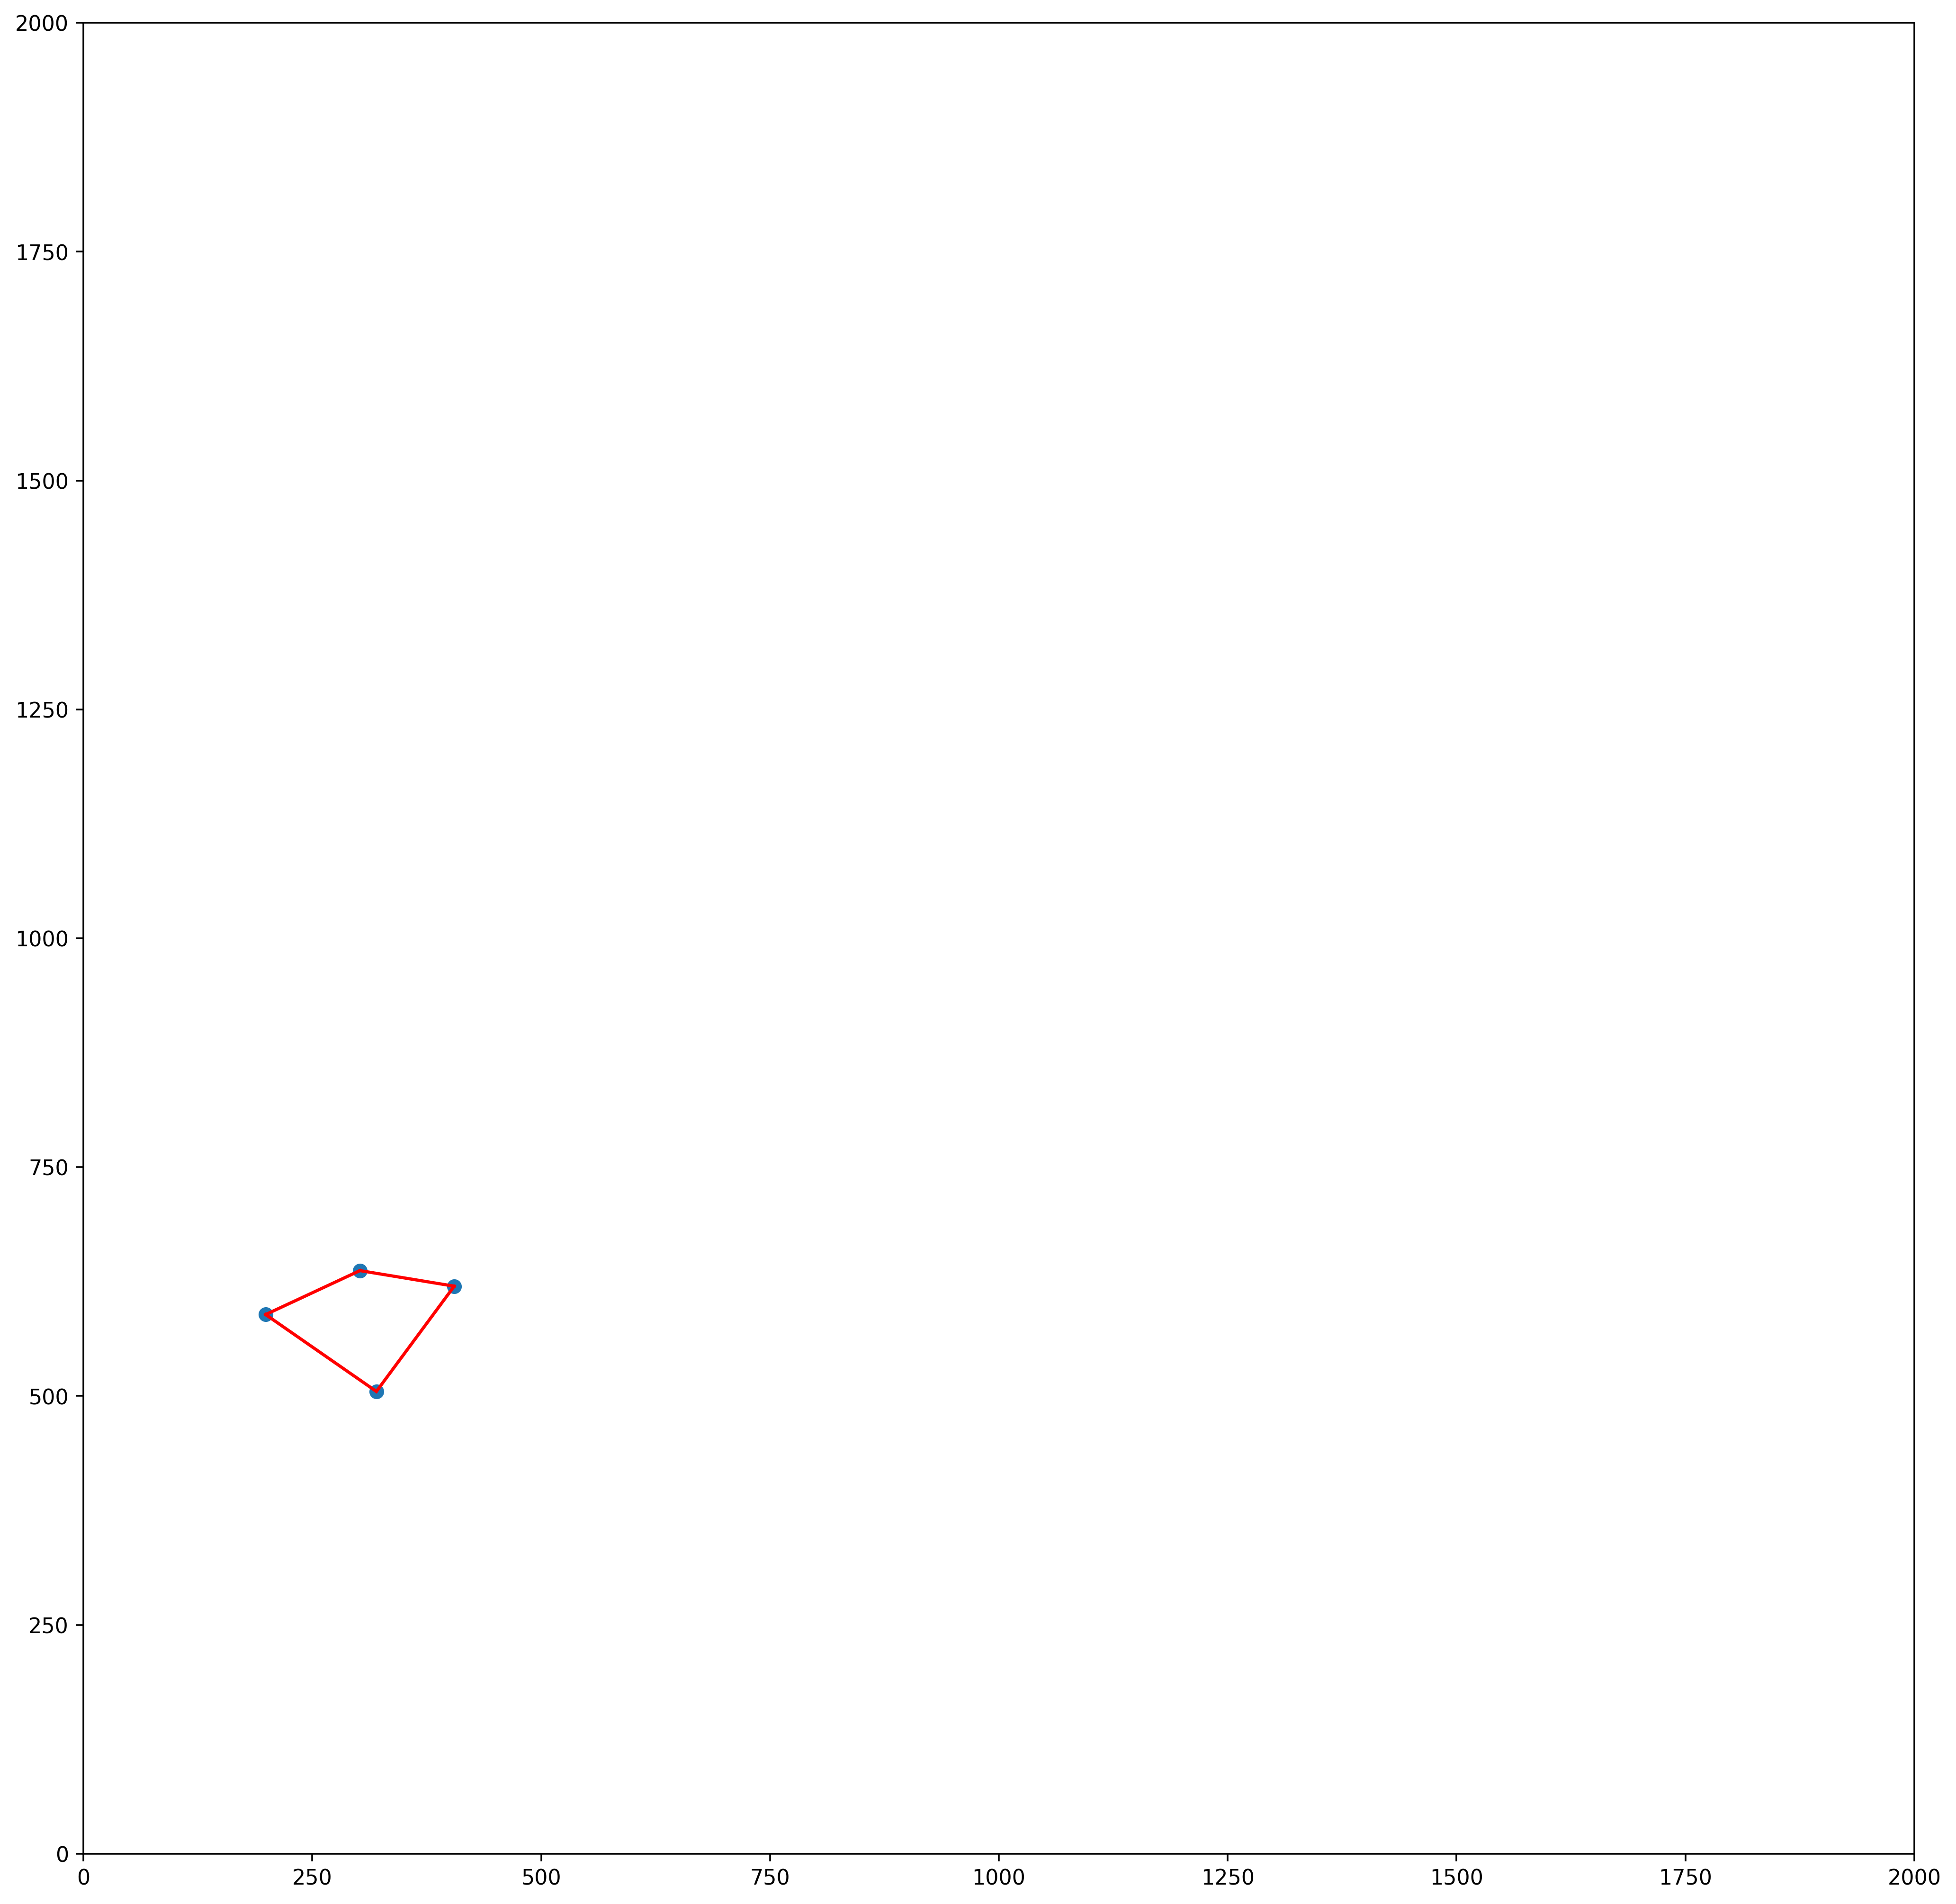

In [4]:
import itertools
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy.spatial import distance

def sample_to_ndarray(sample):
    points = []
    
    for point in sample:
        points.append(point[0])
        points.append(point[1])
    
    return np.array(points)


def render_sample(index):
    df = pd.DataFrame(samples[index], columns=['x', 'y'])
    print(df)
    fig = df.plot.scatter(x='x', y='y', color='red', figsize=(15,15))

    fig.set_xlim([0, 2000])
    fig.set_ylim([0, 2000])

    plt.gca().set_aspect('equal', adjustable='box')
    plt.ylabel('some numbers')

    plt.show()

def convex_hull(sample):
    # convert points of sample to ndarray
    points = np.asarray(sample)
    
    # find the convex hull
    hull = ConvexHull(points)    
   
    plt.figure(num=None, figsize=(18, 16), dpi=320, facecolor='w', edgecolor='r')
    
    plt.xlim([0,2000]) 
    plt.ylim([0,2000]) 

    # plot the original points
    plt.plot(points[:, 0], points[:, 1], 'o')

    # plot the convex hull around it
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'r')

    # adjustment to coordinate system
    plt.gca().set_aspect('equal', adjustable='box')
    
    # display that crap
    plt.show()


def get_distances_for_sample(sample):
    oy = sample[0]
    ox = sample[1]
    tc = sample[2] # part of the code
    origin = sample[3] # origin

    return[distance.euclidean(origin, ox), distance.euclidean(origin, oy),distance.euclidean(ox, oy),distance.euclidean(tc, origin) ]
    

def get_statistics_for_sampleset(sampleset):
    dst_origin_ox = []
    dst_origin_oy = []
    dst_ox_oy = []
    dst_origin_tc = []

    for i in range(0,9): 
        sample = samples[0b10000000][i]
        distances = get_distances_for_sample(sample)
        
        dst_origin_ox.append(distances[0])
        dst_origin_oy.append(distances[1])
        dst_ox_oy.append(distances[2])
        dst_origin_tc.append(distances[3])

    print("dst(origin,x): mean({0}), max({1}, min({2}))".format(np.mean(dst_origin_ox), np.max(dst_origin_ox), np.min(dst_origin_ox)))
    print("dst(origin,y): mean({0}), max({1}, min({2}))".format(np.mean(dst_origin_oy), np.max(dst_origin_oy), np.min(dst_origin_oy)))
    print("dst(ox,oy): mean({0}), max({1}, min({2}))".format(np.mean(dst_ox_oy), np.max(dst_ox_oy), np.min(dst_ox_oy)))
    print("dst(origin,tc): mean({0}), max({1}, min({2}))".format(np.mean(dst_origin_tc), np.max(dst_origin_tc), np.min(dst_origin_tc)))

    
sample = samples[0x10][3]
om = get_orientation_marks(sample)
print(norm(om, sample[2]))

convex_hull(sample)
#get_statistics_for_sampleset(samples[0x80])



In [5]:
sample = samples[0x1][0]
print(sample)
print(check_touchcode(sample))
print(check_touchcode(samples[0x10][1]))
print(check_touchcode(None))
print(check_touchcode_str("[(0,0),(0,3),(3,0),(2,3),(1,3)]", x_mirror=False))
print(check_touchcode_str("+++A LOT OF GARGABE+++"))


[(360, 483), (523, 620), (366, 631), (413, 488)]
1
16
-1
3
-1


In [6]:
import numpy as np

# v1 . v2 = |v1| |v2| cos(a)
# <=> a = cos-1( (v1.v2) / |v1||v2| )

# 5 degrees tolerance is fine!

def debug_vectors(v1, v2):
    print("v1: {0}, v2: {1}".format(v1, v2))
    print("Angle: {0}".format(v_angle(v1, v2)))
    print("Perpendicular: {0}". format(v_perpendicular(v1, v2, 4)))
    print("Parallel: {0}".format(v_parallel(v1, v2, 3)))
    print("Same Orientation: {0}".format(v_same_orientation(v1, v2)))
    print("Dot product: {0}\n".format(np.dot(v1, v2)))

def debug_all_samples(): 
    for sample in samples[0x10] + samples[0x80]:
        va = np.array(sample[1])
        vb = np.array(sample[0])
        o = np.array(sample[3])
        s = np.array(sample[2])

        v1 = (va - o) / np.linalg.norm((va - o))
        v2 = (vb - o) / np.linalg.norm((vb - o))

        debug_vectors(v1, v2)

# vy (1486,68)
# vx (1638,213)
# s  (1581,119)
# o  (1628,69)
        
    
debug_all_samples()


va = np.array([1638, 213]) 
vb = np.array([1486, 68]) 
o = np.array([1628, 69])

real_origin = np.array([0, 0])
translate = real_origin - o

ot = o + translate

vat = (va + translate)
vbt = (vb + translate)

debug_vectors(va - o, vb - o)
debug_vectors(vat, vbt)

print("va: {0}, vb: {1}".format(va,vb))
print("vat: {0}, vbt: {1}".format(vat,vbt))

v1: [-0.40613847 -0.91381155], v2: [ 0.90672111 -0.42173075]
Angle: 89.0
Perpendicular: True
Parallel: False
Same Orientation: True
Dot product: 0.017128107977705753

v1: [ 0.94097368 -0.33847974], v2: [ 0.38897204  0.92124956]
Angle: 87.0
Perpendicular: True
Parallel: False
Same Orientation: True
Dot product: 0.054188136120129904

v1: [-0.66640903  0.74558635], v2: [-0.76822128 -0.6401844 ]
Angle: 88.0
Perpendicular: True
Parallel: False
Same Orientation: True
Dot product: 0.03463685420954571

v1: [ 0.59439106  0.80417614], v2: [-0.82145831  0.57026858]
Angle: 92.0
Perpendicular: True
Parallel: False
Same Orientation: False
Dot product: -0.029671091078491252

v1: [-0.82118879 -0.57065662], v2: [ 0.53966611 -0.84187914]
Angle: 88.0
Perpendicular: True
Parallel: False
Same Orientation: True
Dot product: 0.0372561373695518

v1: [-0.51245751 -0.85871258], v2: [ 0.86478895 -0.50213552]
Angle: 91.0
Perpendicular: True
Parallel: False
Same Orientation: False
Dot product: -0.01197750242716183

c:\python35\lib\site-packages\ipykernel\__main__.py:23: RuntimeWarning: invalid value encountered in arccos
